In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean

In [2]:
import utils_generic as generic
import multitask_simple as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.roberta_conf

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset(convai_train,tasks,model_conf) 
convai_val_token = generic.tokenize_dataset(convai_val,tasks,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultiTaskSimple(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultiTaskSimple(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset(md_data,tasks,model_conf) 
md_dataset = mt.DatasetMultiTaskSimple(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.056024410168053 	 Validation loss: 2.0042981576111356 	 
  1%|          | 574/57400 [01:36<3:11:15,  4.95it/s]
Epoch 2 	 Training loss: 1.9961548929430466 	 Validation loss: 1.9842265844345093 	 
  2%|▏         | 1148/57400 [03:12<2:33:42,  6.10it/s]
Epoch 3 	 Training loss: 1.9862131856459775 	 Validation loss: 1.9789534120236414 	 
  3%|▎         | 1722/57400 [04:47<2:32:47,  6.07it/s]
Epoch 4 	 Training loss: 1.9804423416117758 	 Validation loss: 1.9696399155309645 	 
  4%|▍         | 2296/57400 [06:23<2:17:48,  6.66it/s]
Epoch 5 	 Training loss: 1.9749172637271548 	 Validation loss: 1.9666064937235945 	 
  5%|▌         | 2870/57400 [07:58<2:17:26,  6.61it/s]
Epoch 6 	 Training loss: 1.9732648181998356 	 Validation loss: 1.9682780827506114 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:33<2:57:47,  5.06it/s]
Epoch 7 	 Training loss: 1.9721907483160703 	 Validation loss: 1.9720788103038982 	 

2 epoch without improvement
  7%|▋         | 40

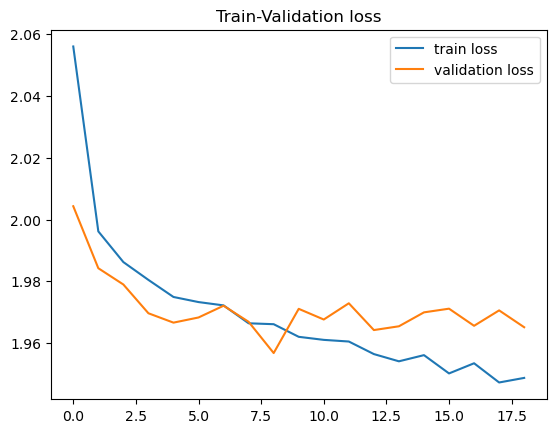

In [12]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_simple_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7209595959595959, 'precision': 0.7209595959595959, 'f1': 0.7209595959595958, 'accuracy': 0.7209595959595959}, 'as': {'recall': 0.7405475880052151, 'precision': 0.7405475880052151, 'f1': 0.7405475880052153, 'accuracy': 0.7405475880052151}, 'about': {'recall': 0.8418367346938775, 'precision': 0.8418367346938775, 'f1': 0.8418367346938774, 'accuracy': 0.8418367346938775}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7372262773722628, 'precision': 0.7372262773722628, 'f1': 0.7372262773722628, 'accuracy': 0.7372262773722628}, 'as': {'recall': 0.7474747474747475, 'precision': 0.7474747474747475, 'f1': 0.7474747474747475, 'accuracy': 0.7474747474747475}, 'about': {'recall': 0.8515625, 'precision': 0.8515625, 'f1': 0.8515625, 'accuracy': 0.8515625}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7034120734908137, 'precision': 0.7034120734908137, 'f1': 0.7034120734908137, 'accuracy': 0.7034120734908137}, 'as': {'recall': 0.7331536388140162, '

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0431261131157026 	 Validation loss: 1.9857445894661596 	 
  1%|          | 574/57400 [01:34<2:26:59,  6.44it/s]
Epoch 2 	 Training loss: 1.9910940448996912 	 Validation loss: 1.983822618500661 	 
  2%|▏         | 1148/57400 [03:09<2:29:18,  6.28it/s]
Epoch 3 	 Training loss: 1.9855564975987743 	 Validation loss: 1.975986272601758 	 
  3%|▎         | 1722/57400 [04:43<2:21:08,  6.57it/s]
Epoch 4 	 Training loss: 1.975867245878492 	 Validation loss: 1.966260962567087 	 
  4%|▍         | 2296/57400 [06:19<2:20:56,  6.52it/s]
Epoch 5 	 Training loss: 1.9699566129608022 	 Validation loss: 1.970674595590365 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [07:54<2:38:02,  5.75it/s]
Epoch 6 	 Training loss: 1.970055606930098 	 Validation loss: 1.970234527426251 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [09:27<2:22:02,  6.33it/s]
Epoch 7 	 Training loss: 1.9670471125363473 	 Validation loss: 1.9705925210047577 	 

3 epoch without improvem

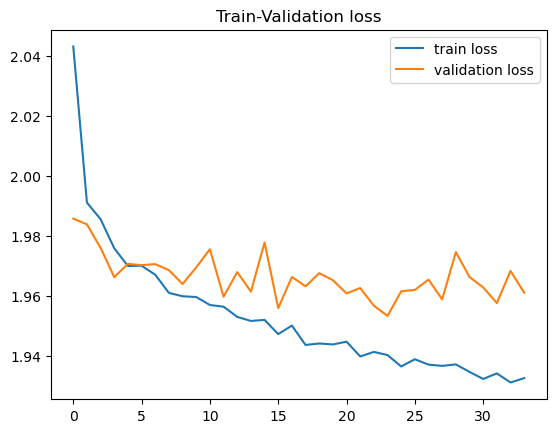

In [14]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_simple_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7171717171717171, 'precision': 0.7171717171717171, 'f1': 0.7171717171717171, 'accuracy': 0.7171717171717171}, 'as': {'recall': 0.7379400260756193, 'precision': 0.7379400260756193, 'f1': 0.7379400260756194, 'accuracy': 0.7379400260756193}, 'about': {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7201946472019465, 'precision': 0.7201946472019465, 'f1': 0.7201946472019465, 'accuracy': 0.7201946472019465}, 'as': {'recall': 0.7146464646464646, 'precision': 0.7146464646464646, 'f1': 0.7146464646464646, 'accuracy': 0.7146464646464646}, 'about': {'recall': 0.8307291666666666, 'precision': 0.8307291666666666, 'f1': 0.8307291666666666, 'accuracy': 0.8307291666666666}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7139107611548556, 'precision': 0.7139107611548556, 'f1': 0.7139107611548556, 'accuracy': 0.7139107611548556}, 'a

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0461818004734424 	 Validation loss: 1.99498006650957 	 
  1%|          | 574/57400 [01:34<2:07:38,  7.42it/s]
Epoch 2 	 Training loss: 1.9945962412432097 	 Validation loss: 1.9899159387006597 	 
  2%|▏         | 1148/57400 [03:08<2:40:59,  5.82it/s]
Epoch 3 	 Training loss: 1.9860814955176376 	 Validation loss: 1.978458321700662 	 
  3%|▎         | 1722/57400 [04:43<2:27:36,  6.29it/s]
Epoch 4 	 Training loss: 1.9807441959397718 	 Validation loss: 1.9796582157328977 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [06:17<2:15:44,  6.77it/s]
Epoch 5 	 Training loss: 1.9743493735167208 	 Validation loss: 1.9731898812924402 	 
  5%|▌         | 2870/57400 [07:50<2:16:38,  6.65it/s]
Epoch 6 	 Training loss: 1.9706588568172387 	 Validation loss: 1.981470301999884 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [09:24<2:26:29,  6.14it/s]
Epoch 7 	 Training loss: 1.9678218252567463 	 Validation loss: 1.9696383799536754 	 
  7%|▋         | 4018/

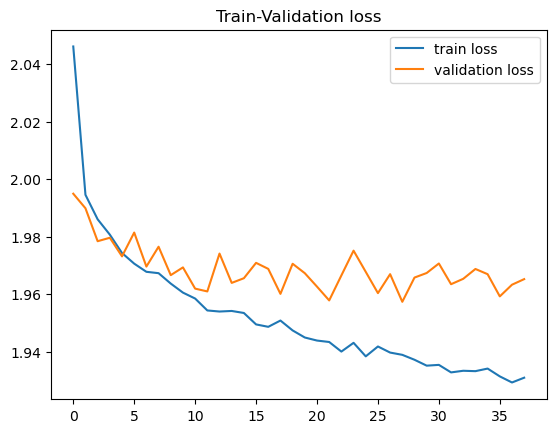

In [16]:
model = mt.MultiTaskSimple(model_conf).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='roberta_multitask_simple_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiTaskSimple(model_conf).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.7373737373737373, 'precision': 0.7373737373737373, 'f1': 0.7373737373737375, 'accuracy': 0.7373737373737373}, 'as': {'recall': 0.7366362451108214, 'precision': 0.7366362451108214, 'f1': 0.7366362451108214, 'accuracy': 0.7366362451108214}, 'about': {'recall': 0.8545918367346939, 'precision': 0.8545918367346939, 'f1': 0.8545918367346939, 'accuracy': 0.8545918367346939}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7274939172749392, 'precision': 0.7274939172749392, 'f1': 0.7274939172749392, 'accuracy': 0.7274939172749392}, 'as': {'recall': 0.7272727272727273, 'precision': 0.7272727272727273, 'f1': 0.7272727272727273, 'accuracy': 0.7272727272727273}, 'about': {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.7480314960629921, 'precision': 0.7480314960629921, 'f1': 0.7480314960629921, 'accuracy': 0.7480314960629921}, 'a

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8473639455782312, 'precision': 0.8473639455782312, 'f1': 0.8473639455782312, 'accuracy': 0.8473639455782312}
Métricas etiqueta male: {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}
Métricas etiqueta female:  {'recall': 0.8508333333333333, 'precision': 0.8508333333333333, 'f1': 0.8508333333333332, 'accuracy': 0.8508333333333333}

 to
Resultado global: {'recall': 0.7251683501683501, 'precision': 0.7251683501683501, 'f1': 0.7251683501683501, 'accuracy': 0.7251683501683501}
Métricas etiqueta male: {'recall': 0.7283049472830495, 'precision': 0.7283049472830495, 'f1': 0.7283049472830495, 'accuracy': 0.7283049472830495}
Métricas etiqueta female:  {'recall': 0.7217847769028871, 'precision': 0.7217847769028871, 'f1': 0.7217847769028871, 'accuracy': 0.7217847769028871}

 as
Resultado global: {'recall': 0.738374619730552, 'precision': 0.738374619730552, 'f1': 0.738374619730552, 'accuracy': 0.738374619730552}